<a href="https://colab.research.google.com/github/KazGet/Summer_prac_ML/blob/main/Summer_practies_4_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Импорт библиотек
!pip install -U catboost
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive; drive.mount('/content/drive')
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, RocCurveDisplay, roc_auc_score, make_scorer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
!pip install optuna
import optuna
# !pip install missforest
# from missforest import MissForest
import shap
# !pip install boruta
# from boruta import BorutaPy
import itertools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.1 MB/s eta 0:00:00


In [ ]:
# @title Импорт основого файла и предобработка данных
file = "/content/TASK_4.xlsx"
df = pd.read_excel(file, sheet_name=0)
#Задача - предсказание плохого прогноза — значение 1 в графе MH по данным стресс-ЭхоКГ — графы СR-GJ.
indices_to_drop = list(range(0, 95)) + list(range(192, 345)) + list(range(346, len(df.columns)))
df = df.drop(df.columns[indices_to_drop], axis=1)
df=df.drop(['DTE rest', 'Minutes Exercise', 'Sat O2 rest', "GLS RV rest", "GLS RV stress", 'DTE stress', 'SBP rest', 'IMM rest', 'S RV  stress', 'DBP stress',
            'LVESVi stress', 'LVESVi at rest', 'Peak ECG'], axis=1)
df=df.rename(columns={'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма': 'Phenotype_Стресс'})

categorical_features = ['Reason of Stress Stop']
df[categorical_features] = df[categorical_features].fillna("NaN").astype(str)

X = df.drop('FU1+2+3 coronary event (Death+AMI+ACS+Revasc)', axis=1)
y = df['FU1+2+3 coronary event (Death+AMI+ACS+Revasc)']

mask = df['FU1+2+3 coronary event (Death+AMI+ACS+Revasc)'].isin([0, 1])
X = X[mask]
y = y[mask]

# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# X[categorical_features] = encoder.fit_transform(X[categorical_features])
# X.columns = X.columns.astype(str)
# X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

In [ ]:
# @title Удаление полупустых признаков и заполнение медианой
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.5].index
df_dropped = df.drop(cols_to_drop, axis=1)

X_dropped = df_dropped.drop('FU1+2+3 coronary event (Death+AMI+ACS+Revasc)', axis=1)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_dropped[categorical_features] = encoder.fit_transform(X_dropped[categorical_features])
X_dropped = X_dropped[mask]

imputer = SimpleImputer(strategy='median')
X_filled = imputer.fit_transform(X_dropped)
X_filled_data = pd.DataFrame(X_filled, columns=X_dropped.columns)

In [ ]:
# @title Заполнение методом KNNImputer
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))

imputer = KNNImputer(n_neighbors=10)
df_imputed_scaled = imputer.fit_transform(df_scaled)
df_KNN = scaler.inverse_transform(df_imputed_scaled)
df_final = pd.DataFrame(df_KNN, columns=X.columns)

In [ ]:
# @title Заполнение пропусков методом Iterative Imputer
imputer = IterativeImputer(max_iter=20, random_state=0)
df_imputed = imputer.fit_transform(X)
df_MICE = pd.DataFrame(df_imputed, columns=X.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# @title Заполнение пропусков методом MissForest
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_miss_forest = mf.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [08:16<00:00, 99.26s/it] 
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process

In [ ]:
# @title PCA
fig, axes = plt.subplots(4, 1, figsize=(6, 13))

datasets = [
    ("X_med", X_filled_data),
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]


for ax, (name, data) in zip(axes, datasets):
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# @title Отбор признаков по матрице весов PCA
X_numeric = X_filled_data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]
    # return loadings_df.loc[component]

new_X = []
for i in range(1, 41):
  new_X.append(get_most_important_features(f'PC{i}', loadings_df))
  # print(get_most_important_features(f'PC{i}', loadings_df, n_features=1))

print(new_X)
# # Визуализируем нагрузки для первых 10 компонент
# plt.figure(figsize=(15, 8))
# sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False) # annot=True, если признаков не слишком много
# plt.title('Тепловая карта нагрузок PCA (первые 10 компонент)')
# plt.show()

[LVEDV stress    0.268254
Name: PC1, dtype: float64, ABCDE score+ECG    0.320558
Name: PC2, dtype: float64, Diast dysfunc  range    0.251967
Name: PC3, dtype: float64, e'  stress    0.251798
Name: PC4, dtype: float64, A  stress    0.258725
Name: PC5, dtype: float64, GLS delta    0.352474
Name: PC6, dtype: float64, E rest    0.277674
Name: PC7, dtype: float64, ECG range    0.272866
Name: PC8, dtype: float64, B-lines stress    0.307773
Name: PC9, dtype: float64, delta EF    0.2972
Name: PC10, dtype: float64, HR rest    0.285303
Name: PC11, dtype: float64, LAD at rest    0.312574
Name: PC12, dtype: float64, LAD stress    0.294506
Name: PC13, dtype: float64, TAPSE  stress    0.25192
Name: PC14, dtype: float64, MR rest    0.335097
Name: PC15, dtype: float64, СFVR range    0.297752
Name: PC16, dtype: float64, DBP rest    0.29039
Name: PC17, dtype: float64, Diast dysfunc rest    0.345424
Name: PC18, dtype: float64, LAD stress    0.320346
Name: PC19, dtype: float64, LAD stress    0.352862
Name

In [ ]:
# @title Рекурсивное исключение признаков (Recursive Feature Elimination, RFE): Модель обучается на всех признаках, затем самый неважный удаляется, и процесс повторяется.
select_num = 7
selector_med = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_med.fit(X_filled, y)
selected_features_med = X_dropped.columns[selector_med.get_support()]
print("Отобранные признаки для данных, заполенными медианой: ")
print(selected_features_med.tolist())

selector_KNN = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_KNN.fit(df_KNN, y)
selected_features_KNN = X.columns[selector_KNN.get_support()]
print(f"Отобранные признаки для данных, заполенными методом ближайших соседей: ")
print(selected_features_KNN.tolist())

selector_MICE = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MICE.fit(df_MICE, y)
selected_features_MICE = X.columns[selector_MICE.get_support()]
print(f"Отобранные признаки для данных, заполенными методом итеративного заполнения: ")
print(selected_features_MICE.tolist())

selector_MissF = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MissF.fit(df_miss_forest, y)
selected_features_MissF = X.columns[selector_MissF.get_support()]
print(f"Отобранные признаки для данных, заполенными методом MissForest: ")
print(selected_features_MissF.tolist())

print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE) & set(selected_features_MissF))
print("\nПересечение первых трех множеств признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE))

Отобранные признаки для данных, заполенными медианой: 
['LV force rest', 'HR stress', 'HRR', 'LVEF% stress', 'GLS stress-', 'D WMSI', 'LV contractile reserve']
Отобранные признаки для данных, заполенными методом ближайших соседей: 
['LV force rest', 'TR vel rest', 'HRR', 'LVEF% stress', 'GLS stress-', 'A  stress', 'D WMSI']
Отобранные признаки для данных, заполенными методом итеративного заполнения: 
['LV force rest', 'TR vel rest', 'HRR', 'GLS stress-', 'E/A stress', "s'  stress", 'D WMSI']
Отобранные признаки для данных, заполенными методом MissForest: 
['MM rest', 'SV rest', 'B-lines at rest', 'A rest', 'E/A rest', 'S RV rest', "s'  stress"]

Пересечение всех признаков: 
set()

Пересечение первых трех множеств признаков: 
{'LV force rest', 'HRR', 'D WMSI', 'GLS stress-'}


In [ ]:
# @title Boruta
dfrf = df_final
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

feat_selector = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    max_iter=1000,
    random_state=0,
    verbose=False
)

feat_selector.fit(dfrf.values, y.values)

selected_mask = feat_selector.support_
selected_features = dfrf.columns[selected_mask]

print("\nОтобранные признаки методом Boruta:")
print(selected_features.tolist())


Отобранные признаки методом Boruta:
['HR stress', 'HRR', 'GLS stress-', 'D WMSI']


In [ ]:
# @title RFECV —  RFE с автоматическим выбором числа признаков через кросс-валидацию
df_test = df_final
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(estimator=RandomForestClassifier(), step=1, cv=cv, scoring='accuracy')
selector.fit(df_test, y)
feature_ranks = selector.ranking_

ranking_df = pd.DataFrame({'feature': X.columns, 'rank': feature_ranks})
ranking_df = ranking_df.sort_values(by='rank')

top_10_features = ranking_df['feature'].head(select_num).tolist()

print("Топ-10 признаков из рейтинга RFECV:")
print(top_10_features)

Топ-10 признаков из рейтинга RFECV:
['DBP rest', 'MM rest', 'HR rest', 'SV rest', 'LVEF% at rest', 'LVEDVi at rest', 'LVESV  rest']


In [ ]:
# @title Отбор признаков методом ANOVA: оценка стат. связи между каждым признаком и целевой переменной
datasets = {
    "медианой": (X_filled, X_dropped.columns),
    "KNN": (df_KNN, X.columns),
    "MICE": (df_MICE, X.columns),
    "MF": (df_miss_forest, X.columns),
}

selected_features_all = {}

for name, (X_data, feature_names) in datasets.items():
    selector = SelectKBest(score_func=f_classif, k=select_num)
    X_selected = selector.fit_transform(X_data, y)
    selected = feature_names[selector.get_support()]
    selected_features_all[name] = set(selected)
    print(f"Отобранные признаки с данными {name}:\n{list(selected)}")
print("\nПересечение всех результатов (медиана ∩ KNN ∩ MICE):")
print(list(
    selected_features_all["медианой"]
    & selected_features_all["KNN"]
    & selected_features_all["MICE"]
))

Отобранные признаки с данными медианой:
['WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными KNN:
['WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными MICE:
['WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными MF:
['DBP rest', 'MM rest', 'LVEDV rest', 'LVESV  rest', 'LVEDVi at rest', 'LVEF% at rest', 'WMSI  rest']

Пересечение всех результатов (медиана ∩ KNN ∩ MICE):
['Phenotype_Стресс', 'ABCDE score+ECG+angina', 'ABCDE score+ECG', 'ABCDE score', 'WMSI range', 'D WMSI', 'WMSI stress']


In [ ]:
# @title Отбор по LassoCV
def run_lasso_selection(X_source, y, name, feature_names):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso_cv', LassoCV(cv=5, max_iter=10000))
    ])

    pipeline.fit(X_source, y)
    best_alpha = pipeline.named_steps['lasso_cv'].alpha_

    print(f"\n{name}: наилучшее значение alpha = {best_alpha:.4f}")

    lasso = Lasso(alpha=best_alpha, max_iter=10000)
    X_scaled = StandardScaler().fit_transform(X_source)
    lasso.fit(X_scaled, y)

    non_zero_coefs = np.where(lasso.coef_ != 0)[0]
    selected = feature_names[non_zero_coefs]

    print(f"\nВыбранные признаки для {name}:\n", selected.tolist())
    return set(selected)

features_median = run_lasso_selection(X_filled, y, "Median", X_dropped.columns)
features_knn    = run_lasso_selection(df_KNN, y, "KNN", X.columns)
features_mice   = run_lasso_selection(df_MICE, y, "MICE", X.columns)
features_mf     = run_lasso_selection(df_miss_forest, y, "MissForest", X.columns)

print("\nПересечение всех признаков:")
intersection = features_median & features_knn & features_mice & features_mf
print(intersection)



Median: наилучшее значение alpha = 0.0279

Выбранные признаки для Median:
 ['LV force rest', 'LAD at rest', 'B-lines at rest', 'TAPSE rest', 'RVSP rest', 'HR stress', 'HRR', 'delta EF', 'WMSI stress', 'GLS stress-', 'GLS reserve', 'RVSP  stress', 'D WMSI', 'WMSI range', 'СFVR range', 'ABCDE score']

KNN: наилучшее значение alpha = 0.0321

Выбранные признаки для KNN:
 ['LV force rest', 'LAD at rest', 'B-lines at rest', 'TAPSE rest', 'TR vel rest', 'RVSP rest', 'HR stress', 'HRR', 'delta EF', 'WMSI stress', 'SV stress', 'GLS stress-', 'D WMSI', 'WMSI range', 'СFVR range', 'ABCDE score']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01615733881414627, tolerance: 0.005861870503597122
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018236110890043733, tolerance: 0.005861870503597122
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062471727454394, tolerance: 0.006024372759856631
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681:


MICE: наилучшее значение alpha = 0.0344

Выбранные признаки для MICE:
 ['LV force rest', 'B-lines at rest', 'TAPSE rest', 'TR vel rest', 'HR stress', 'HRR', 'delta EF', 'WMSI stress', 'GLS stress-', "e'  stress", "s'  stress", 'D WMSI', 'WMSI range', 'СFVR range', 'ABCDE score']

MissForest: наилучшее значение alpha = 0.0321

Выбранные признаки для MissForest:
 ['DBP rest', 'MM rest', 'LVESV  rest', 'WMSI  rest', 'SV rest', 'B-lines at rest', 'A rest', 'HR stress', 'HRR range', 'GLS stress-', 'E/A stress', "s'  stress", 'TR vel  stress', 'Diast dysfunc  range']

Пересечение всех признаков:
{'HR stress', 'GLS stress-', 'B-lines at rest'}


In [ ]:
# @title Объединение методов

#Удалим признаки с >50% пропусков
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.4].index
df_dropped = df.drop(cols_to_drop, axis=1)
X_d = df_dropped.drop('FU1+2+3 coronary event (Death+AMI+ACS+Revasc)', axis=1)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_d[categorical_features] = encoder.fit_transform(X_d[categorical_features])
X_d = X_d[mask]

#Используем IterativeImputer для заполнения оставшихся признаков
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_after_MF = mf.fit_transform(X_d)

imputer = IterativeImputer(max_iter=20, random_state=0)
df_after_MICE = imputer.fit_transform(X_d)
df_after_MICE = pd.DataFrame(df_after_MICE, columns=X_d.columns)

#Масшитабируем
X_numeric = df_after_MICE.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

X_numeric_ = df_after_MF.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled_ = scaler.fit_transform(X_numeric_)

#Сделаем отбор по методу RFE
selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled, y)
selected_features_MICE = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MICE: ")
print(selected_features_MICE.tolist())

selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled_, y)
selected_features_MF = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MF: ")
print(selected_features_MF.tolist())

#Сделаем отбор методом ANOVA
selector_ANOVA = SelectKBest(score_func=f_classif, k=select_num)
X_anova = selector_ANOVA.fit_transform(X_scaled, y)

selector_ANOVA_ = SelectKBest(score_func=f_classif, k=select_num)
X_anova_ = selector_ANOVA_.fit_transform(X_scaled_, y)

scores = selector_ANOVA.scores_
p_values = selector_ANOVA.pvalues_

scores = selector_ANOVA_.scores_
p_values = selector_ANOVA_.pvalues_

selected_featuresMICE = X_d.columns[selector_ANOVA.get_support()]
print(f"\nОтобранные признаки методом ANOVA:\n {list(selected_featuresMICE)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MICE) & set(selected_featuresMICE))

selected_featuresMF = X_d.columns[selector_ANOVA_.get_support()]
print(f"\nОтобранные признаки методом ANOVA (MF):\n {list(selected_featuresMF)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MF) & set(selected_featuresMF))
print(set(selected_features_MICE) & set(selected_featuresMICE) & set(selected_features_MF) & set(selected_featuresMF))

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [06:17<00:00, 75.43s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process 

Отобранные признаки методом RFE+MICE: 
['LVESVi at rest', 'LV force rest', 'GLS rest', 'TR vel rest', 'HR stress', 'HRR', 'LVESVi stress', 'LVEF% stress', 'GLS stress-', 'E/A stress', 'D WMSI', 'LV contractile reserve']
Отобранные признаки методом RFE+MF: 
['MM rest', 'LVESVi at rest', 'B-lines at rest', 'LA vol rest', 'E rest', "E/e' rest", 'SBP stress', 'LVEDV stress', 'Diast dysfunc  stress', 'LV contractile reserve', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score+ECG']

Отобранные признаки методом ANOVA:
 ['Reason of Stress Stop', 'HR stress', 'HRR', 'delta EF', 'Delta EF >=5 - 0, <5 - 1', 'WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 

In [ ]:
# @title XGBoost
# optimal_cols = ['GLS stress-', 'D WMSI', 'LAD at rest', 'RA vol rest', 'B range', 'LA vol rest', 'RVSP  stress', 'SV rest'] #Средняя точность: 0.7012 Средний recall: 0.6563
# optimal_cols = ['Reason of Stress Stop', 'GLS stress-', 'LVEF% stress', 'LVEF% at rest',
#                 'D WMSI', 'ABCDE score+ECG+angina', 'LAD at rest', 'delta EF', 'RVSP  stress'] #Средняя точность: 0.7213 Средний recall: 0.6364
# optimal_cols =['Reason of Stress Stop', 'GLS stress-', 'LVEF% at rest', 'ABCDE score+ECG+angina', 'LAD at rest', 'delta EF', 'RVSP  stress'] #Средняя точность: 0.7128 Средний recall: 0.6636
# optimal_cols = ['Reason of Stress Stop', 'GLS stress-', 'LVEF% stress', 'LVEF% at rest', 'D WMSI', 'ABCDE score+ECG+angina']
# optimal_cols =['Reason of Stress Stop', 'GLS stress-', 'LVEF% at rest', 'ABCDE score+ECG+angina', 'LAD at rest', 'delta EF', 'RA vol rest', 'RVSP  stress']  #0.7042  0.6732
optimal_cols = ['GLS stress-', 'D WMSI', 'B range', 'RVSP  stress']
X_boost=X[optimal_cols]

X_train, X_test, y_train, y_test = train_test_split(X_boost, y, stratify=y, random_state=42, test_size=0.2)

neg = len(y_train[y_train == 0])  # или sum(y_train == 0)
pos = len(y_train[y_train == 1])  # или sum(y_train == 1)
scale_pos_weight = neg / pos
params = {'max_depth': 8, 'learning_rate': 0.38830158686351, 'n_estimators': 188, 'min_child_weight': 2, 'gamma': 2.5968539032497118, 'subsample': 0.9070492409605632, 'colsample_bytree': 0.7562826912266845, 'reg_alpha': 1.319550703563934, 'reg_lambda': 5.973831576646422, 'scale_pos_weight': scale_pos_weight}

model = XGBClassifier(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("\nClassification report:\n", classification_report(y_test, y_pred))
# print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
# y_train_pred_proba = model.predict_proba(X_train)[:, 1]
# print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

# y_pred_proba = model.predict_proba(X_test)[:, 1]
# print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# RocCurveDisplay.from_estimator(model, X_test, y_test)
# plt.show()

# plt.figure(figsize=(20, 12))
# plot_importance(model, max_num_features=len(optimal_cols), importance_type='total_gain')
# plt.title("Наиболее важные признаки")
# plt.show()
# print()
print('_'*150)

test_model = XGBClassifier(**params, random_state=42)
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(test_model, X_boost, y, cv=cv_strategy, scoring='accuracy', verbose=False)
scores_ = cross_val_score(test_model, X_boost, y, cv=cv_strategy, scoring='recall', verbose=False)

# 4. Анализируем результаты
print(f"Оценки точности на каждом фолде: {scores} \nRecall: {scores_}")
print(f"Средняя точность: {scores.mean():.4f} \nСредний recall: {scores_.mean():.4f}")
print(f"Стандартное отклонение: {scores.std():.4f}, {scores_.std():.4f}")

______________________________________________________________________________________________________________________________________________________
Оценки точности на каждом фолде: [0.6        0.8        0.57142857 0.82857143 0.71428571 0.8
 0.65714286 0.8        0.67647059 0.73529412] 
Recall: [0.27272727 1.         0.27272727 0.72727273 0.81818182 0.81818182
 0.54545455 0.8        0.5        0.6       ]
Средняя точность: 0.7183 
Средний recall: 0.6355
Стандартное отклонение: 0.0858, 0.2294


In [ ]:
# @title Метод грубой силы (XGBoost)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_features] = encoder.fit_transform(X[categorical_features])
X.columns = X.columns.astype(str)
X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

optimal_cols = ['GLS stress-', 'D WMSI', 'LAD at rest', 'B range', 'LA vol rest', 'RVSP  stress', 'SV rest']
try:
    XGB_brute_force
except NameError:
    XGB_brute_force = pd.DataFrame(columns=['n_features', 'features', 'weighted_score'])

def weighted_scorer_func(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return 0.5 * acc + 0.5 * rec

custom_scorer = make_scorer(weighted_scorer_func, greater_is_better=True)

already_checked_sets = {tuple(sorted(features)) for features in XGB_brute_force['features']}
print(f"Загружено {len(already_checked_sets)} уже проверенных комбинаций.")

tick = 0
results_this_run = []
come_to_nine = len(optimal_cols)-9 if len(optimal_cols)>9 else 0
X_full = X[optimal_cols]

for k in range(len(optimal_cols) - come_to_nine, 2, -1):
    print(f"\n▶️ Проверка комбинаций с {k} признаками...")

    for subset in itertools.combinations(optimal_cols, k):
        subset_tuple = tuple(sorted(subset))
        if subset_tuple in already_checked_sets:
            tick+=1
            continue

        subset_list = list(subset)
        X_subset = X_full[subset_list]

        model = XGBClassifier(random_state=0, scale_pos_weight = scale_pos_weight)
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model, X_subset, y,
            scoring=custom_scorer, cv=cv_strategy, verbose = False
        )

        mean_weighted_score = np.mean(scores)

        results_this_run.append({
            'n_features': k,
            'features': subset_list,
            'weighted_score': mean_weighted_score
        })

        already_checked_sets.add(subset_tuple)

if results_this_run:
    results_df = pd.DataFrame(results_this_run)
    best = results_df.sort_values(by='weighted_score', ascending=False).iloc[0]

    print("\n✅ Лучшая модель в этом запуске:")
    print(f"- Число признаков: {best['n_features']}")
    print(f"- Средний взвешенный скор: {best['weighted_score']:.4f}")
    print(f"- Используемые признаки: {best['features']}")
    print(f"\n Кол-во случаев, когда модель не обучалась: {tick}")

    XGB_brute_force = pd.concat([XGB_brute_force, results_df], ignore_index=True)
    XGB_brute_force.to_csv("XGB_brute_force.csv", index=False)
else:
    print("\nНовых комбинаций для проверки не найдено!")

Загружено 0 уже проверенных комбинаций.

▶️ Проверка комбинаций с 7 признаками...

▶️ Проверка комбинаций с 6 признаками...

▶️ Проверка комбинаций с 5 признаками...

▶️ Проверка комбинаций с 4 признаками...

▶️ Проверка комбинаций с 3 признаками...

✅ Лучшая модель в этом запуске:
- Число признаков: 4
- Средний взвешенный скор: 0.6018
- Используемые признаки: ['GLS stress-', 'D WMSI', 'B range', 'RVSP  stress']

 Кол-во случаев, когда модель не обучалась: 0


/tmp/ipython-input-23-407705758.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  XGB_brute_force = pd.concat([XGB_brute_force, results_df], ignore_index=True)


In [ ]:
print(XGB_brute_force.sort_values(by='weighted_score', ascending=False).iloc[0]['features'])

['GLS stress-', 'LVEF% at rest', 'D WMSI', 'ABCDE score+ECG+angina', 'LAD at rest', 'delta EF', 'СFVR range', 'RVSP  stress']


Accuracy: 0.6285714285714286
Recall: 0.18181818181818182

Classification report:
               precision    recall  f1-score   support

         0.0       0.69      0.83      0.75        48
         1.0       0.33      0.18      0.24        22

    accuracy                           0.63        70
   macro avg       0.51      0.51      0.50        70
weighted avg       0.58      0.63      0.59        70


Confusion matrix:
 [[40  8]
 [18  4]]
ROC AUC (Train): 0.8415726912526669
ROC AUC: 0.625


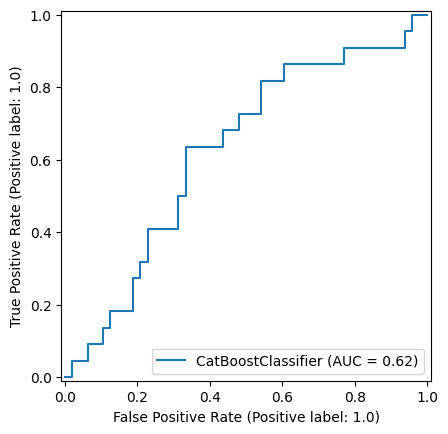

______________________________________________________________________________________________________________________________________________________
Оценки точности на каждом фолде: [0.68571429 0.67142857 0.68571429 0.71014493 0.71014493] 
Recall: [0.36363636 0.18181818 0.19047619 0.28571429 0.33333333]
Средняя точность: 0.6926 
Средний recall: 0.2710
Стандартное отклонение: 0.0152, 0.0736


In [ ]:
# @title CatBoostClassifier

optimal_cols = ['GLS stress-', 'LVEF% stress', 'LVEF% at rest', 'ABCDE score+ECG+angina', 'RVSP  stress', 'HRR range']

 #0.7067
optimal_cols = ['GLS stress-', 'delta EF', 'ABCDE score+ECG+angina', 'RVSP  stress', 'HRR range'] #0.729
# optimal_cols = ['LAD at rest', 'delta EF', 'GLS stress-', 'СFVR range', 'ABCDE score+ECG+angina'] #0.7129
# optimal_cols = ['Reason of Stress Stop', 'GLS stress-', 'D WMSI', 'ABCDE score+ECG+angina', 'RA vol rest', 'B range', 'delta EF'] #0.71
# optimal_cols = ['GLS stress-', 'LVEF% at rest', 'D WMSI', 'LA vol rest', 'LAD at rest', 'RVSP  stress'] #0.71
# optimal_cols = ['Reason of Stress Stop', 'GLS stress-', 'LVEF% stress', 'LVEF% at rest', 'ABCDE score+ECG+angina', 'RVSP  stress']
# optimal_cols = ['Reason of Stress Stop', 'GLS stress-', 'ABCDE score+ECG+angina', 'LAD at rest', 'delta EF', 'СFVR range', 'RA vol rest', 'LA vol rest', 'SV rest']

# ['GLS stress-', 'D WMSI', 'LAD at rest', 'RA vol rest', 'B range', 'LA vol rest', 'RVSP  stress', 'SV rest']
cat_features = [i for i in categorical_features if i in optimal_cols]

X_boost = X[optimal_cols]
X_train, X_test, y_train, y_test = train_test_split(X_boost, y, test_size=0.2, random_state=0, stratify=y)
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

neg = len(y_train[y_train == 0])  # или sum(y_train == 0)
pos = len(y_train[y_train == 1])  # или sum(y_train == 1)
scale_pos_weight = neg / pos

params =   {'iterations': 157, 'learning_rate': 0.01086103702591857, 'depth': 7, 'l2_leaf_reg': 9.363409286020953, 'random_strength': 0.32741067746544694, 'bagging_temperature': 0.9186308230989952, 'border_count': 129}

cat_model = CatBoostClassifier(**params, verbose = False)
cat_model.fit(train_pool)
y_pred = cat_model.predict(test_pool)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

y_train_pred_proba = cat_model.predict_proba(train_pool)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = cat_model.predict_proba(test_pool)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(cat_model, X_test, y_test)
plt.show()


importances = cat_model.feature_importances_
indices = np.argsort(importances)[::-1]

# # Вывод важности признаков
# for i in range(len(optimal_cols)):
#     print(f"{optimal_cols[indices[i]]}: {importances[indices[i]]:.4f}")

print('_'*150)

X_cv = X_boost.copy()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_cv[cat_features] = encoder.fit_transform(X_cv[cat_features])
test_model = CatBoostClassifier(**params, random_state=42, verbose=False)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(test_model, X_cv, y, cv=cv_strategy, scoring='accuracy', verbose=False)
scores_ = cross_val_score(test_model, X_cv, y, cv=cv_strategy, scoring='recall', verbose=False)

# 4. Анализируем результаты
print(f"Оценки точности на каждом фолде: {scores} \nRecall: {scores_}")
print(f"Средняя точность: {scores.mean():.4f} \nСредний recall: {scores_.mean():.4f}")
print(f"Стандартное отклонение: {scores.std():.4f}, {scores_.std():.4f}")

In [ ]:
# @title Метод грубой силы (CatBoost)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
optimal_cols = [
    'Reason of Stress Stop',
    'GLS stress-',
    'LVEF% stress',
    'LVEF% at rest',
    'D WMSI',
    'ABCDE score+ECG+angina',
    'LAD at rest',
    'delta EF',
    'СFVR range',
    'RA vol rest',
    'B range',
    'E/A rest',
    'LA vol rest',
    'RVSP  stress',
    'HRR range',
    'SV rest'
]
try:
    results_brute_force
except NameError:
    results_brute_force = pd.DataFrame(columns=['n_features', 'features', 'weighted_score'])

params =  {'iterations': 100, 'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 9.663540417193897, 'random_strength': 1.5, 'scale_pos_weight': scale_pos_weight, "loss_function": "Logloss"}

def weighted_scorer_func(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return 0.5 * acc + 0.5 * rec

custom_scorer = make_scorer(weighted_scorer_func, greater_is_better=True)

already_checked_sets = {tuple(sorted(features)) for features in results_brute_force['features']}
print(f"Загружено {len(already_checked_sets)} уже проверенных комбинаций.")

tick = 0
results_this_run = []
come_to_nine = len(optimal_cols)-9 if len(optimal_cols)>9 else 0
X_full = X[optimal_cols]

for k in range(len(optimal_cols) - come_to_nine, 2, -1):
    print(f"\n▶️ Проверка комбинаций с {k} признаками...")

    for subset in itertools.combinations(optimal_cols, k):
        subset_tuple = tuple(sorted(subset))
        if subset_tuple in already_checked_sets:
            tick+=1
            continue

        subset_list = list(subset)
        X_subset = X_full[subset_list]
        cat_features_in_subset = [col for col in subset_list if col in categorical_features]

        model = CatBoostClassifier(**params, random_state=0, verbose=False)
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        X_cv_sub = X_subset.copy()
        encoder_local = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        X_cv_sub[cat_features_in_subset] = encoder_local.fit_transform(X_cv_sub[cat_features_in_subset])

        scores = cross_val_score(
            model, X_cv_sub, y,
            scoring='accuracy', cv=cv_strategy, verbose = False
        )

        mean_weighted_score = np.mean(scores)

        results_this_run.append({
            'n_features': k,
            'features': subset_list,
            'weighted_score': mean_weighted_score
        })

        already_checked_sets.add(subset_tuple)

if results_this_run:
    results_df = pd.DataFrame(results_this_run)
    best = results_df.sort_values(by='weighted_score', ascending=False).iloc[0]

    print("\n✅ Лучшая модель в этом запуске:")
    print(f"- Число признаков: {best['n_features']}")
    print(f"- Средний взвешенный скор: {best['weighted_score']:.4f}")
    print(f"- Используемые признаки: {best['features']}")
    print(f"\n Кол-во случаев, когда модель не обучалась: {tick}")

    results_brute_force = pd.concat([results_brute_force, results_df], ignore_index=True)
    results_brute_force.to_csv("results_brute_force.csv", index=False)
else:
    print("\nНовых комбинаций для проверки не найдено!")

Загружено 50506 уже проверенных комбинаций.

▶️ Проверка комбинаций с 9 признаками...

▶️ Проверка комбинаций с 8 признаками...

▶️ Проверка комбинаций с 7 признаками...

▶️ Проверка комбинаций с 6 признаками...

▶️ Проверка комбинаций с 5 признаками...

▶️ Проверка комбинаций с 4 признаками...

▶️ Проверка комбинаций с 3 признаками...

Новых комбинаций для проверки не найдено!


In [ ]:
print(results_brute_force.sort_values(by='weighted_score', ascending=False).iloc[0]['features'])
print(results_brute_force.shape)

['GLS stress-', 'D WMSI', 'LAD at rest', 'RA vol rest', 'B range', 'LA vol rest', 'RVSP  stress', 'SV rest']
(50506, 3)


In [ ]:
print(X_boost.columns)

Index(['Reason of Stress Stop', 'GLS stress-', 'LVEF% stress', 'LVEF% at rest',
       'D WMSI', 'ABCDE score+ECG+angina'],
      dtype='object')


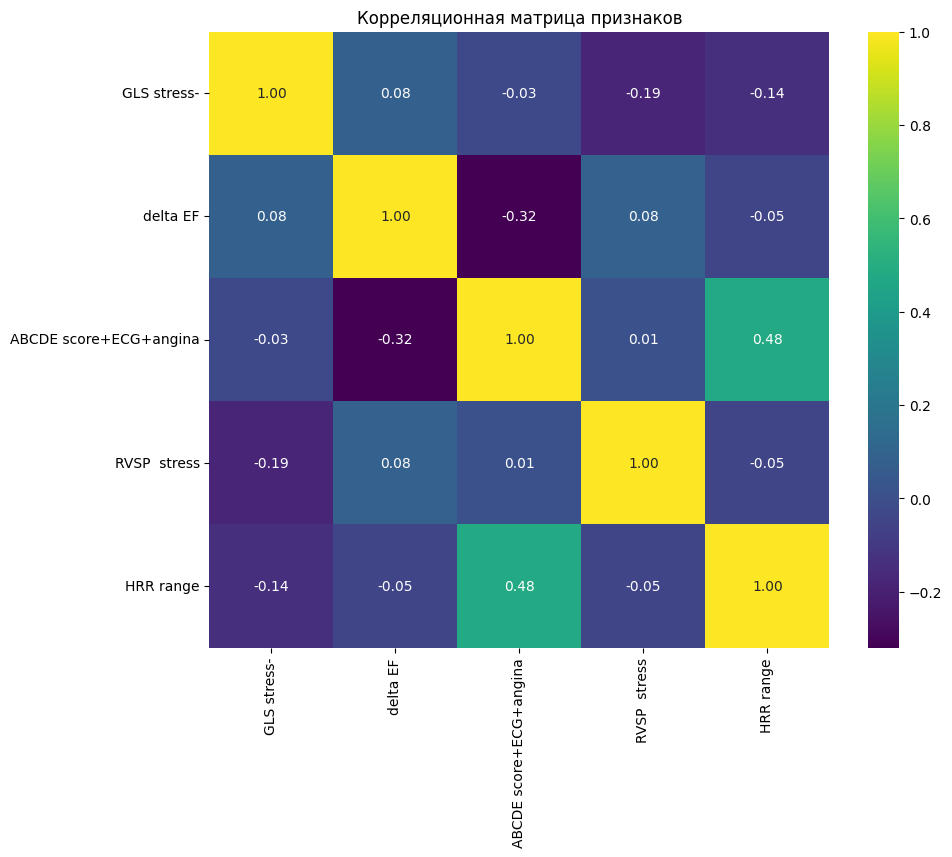

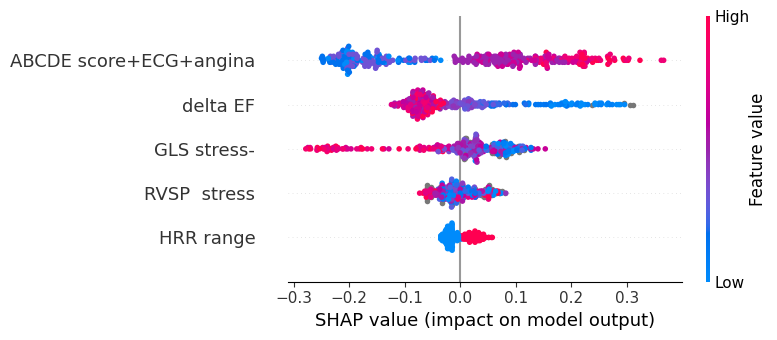

In [ ]:
# @title Матрица корреляции для отобранных признаков и Shap
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_corr = X_boost.copy()
X_corr[cat_features] = encoder.fit_transform(X_corr[cat_features])

corr_matrix = X_corr.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")

plt.title('Корреляционная матрица признаков')
plt.show()

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_boost)
shap.summary_plot(shap_values, X_boost)

df_KNN: Компоненты, объясняющие 95% дисперсии = 4
df_MICE: Компоненты, объясняющие 95% дисперсии = 4
df_MissForest: Компоненты, объясняющие 95% дисперсии = 4


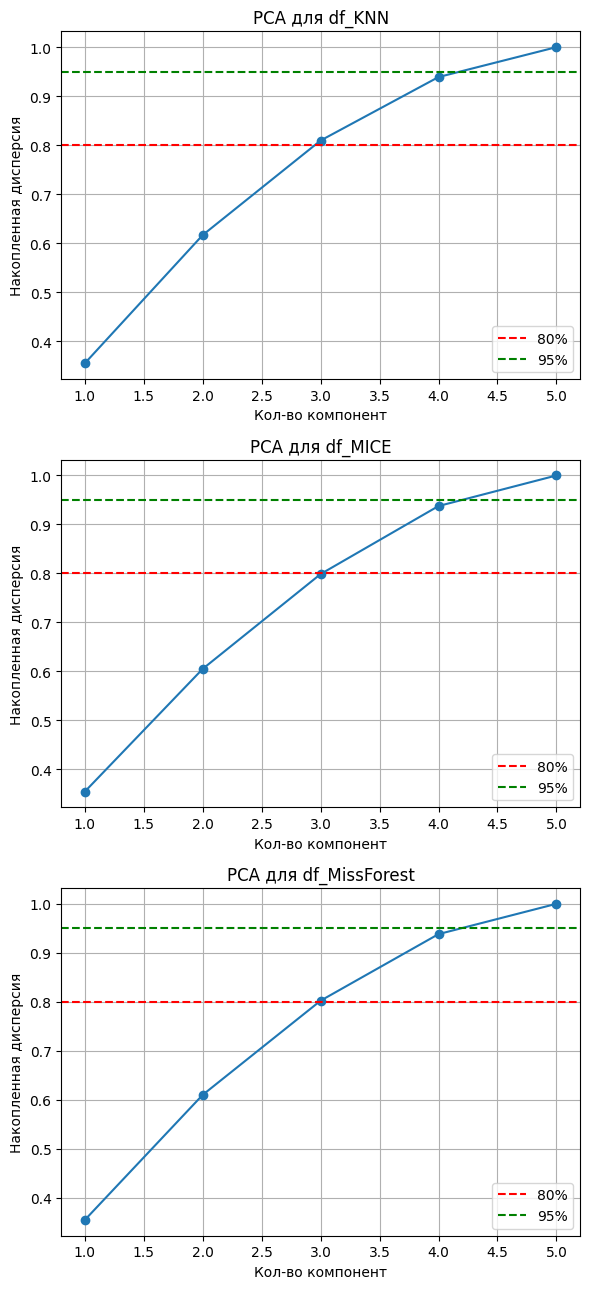

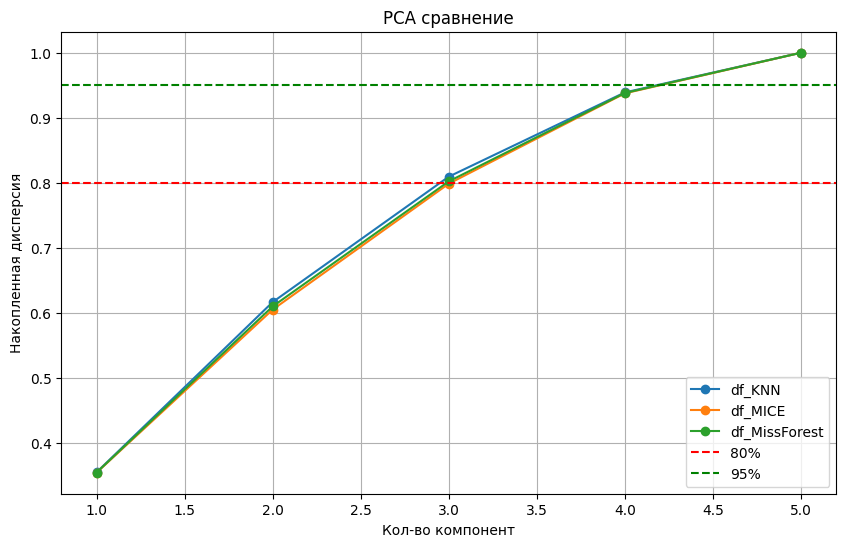

In [ ]:
# @title PCA для отобранных признаков
fig, axes = plt.subplots(3, 1, figsize=(6, 13))

datasets = [
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


ABCDE score    0.595195
Name: PC1, dtype: float64
GLS stress-    0.61513
Name: PC2, dtype: float64
B range    0.706114
Name: PC3, dtype: float64
HRR    0.749308
Name: PC4, dtype: float64
LA vol rest    0.722558
Name: PC5, dtype: float64
LVESVi stress    0.674953
Name: PC6, dtype: float64
Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма    0.730316
Name: PC7, dtype: float64
ABCDE score    0.76118
Name: PC8, dtype: float64


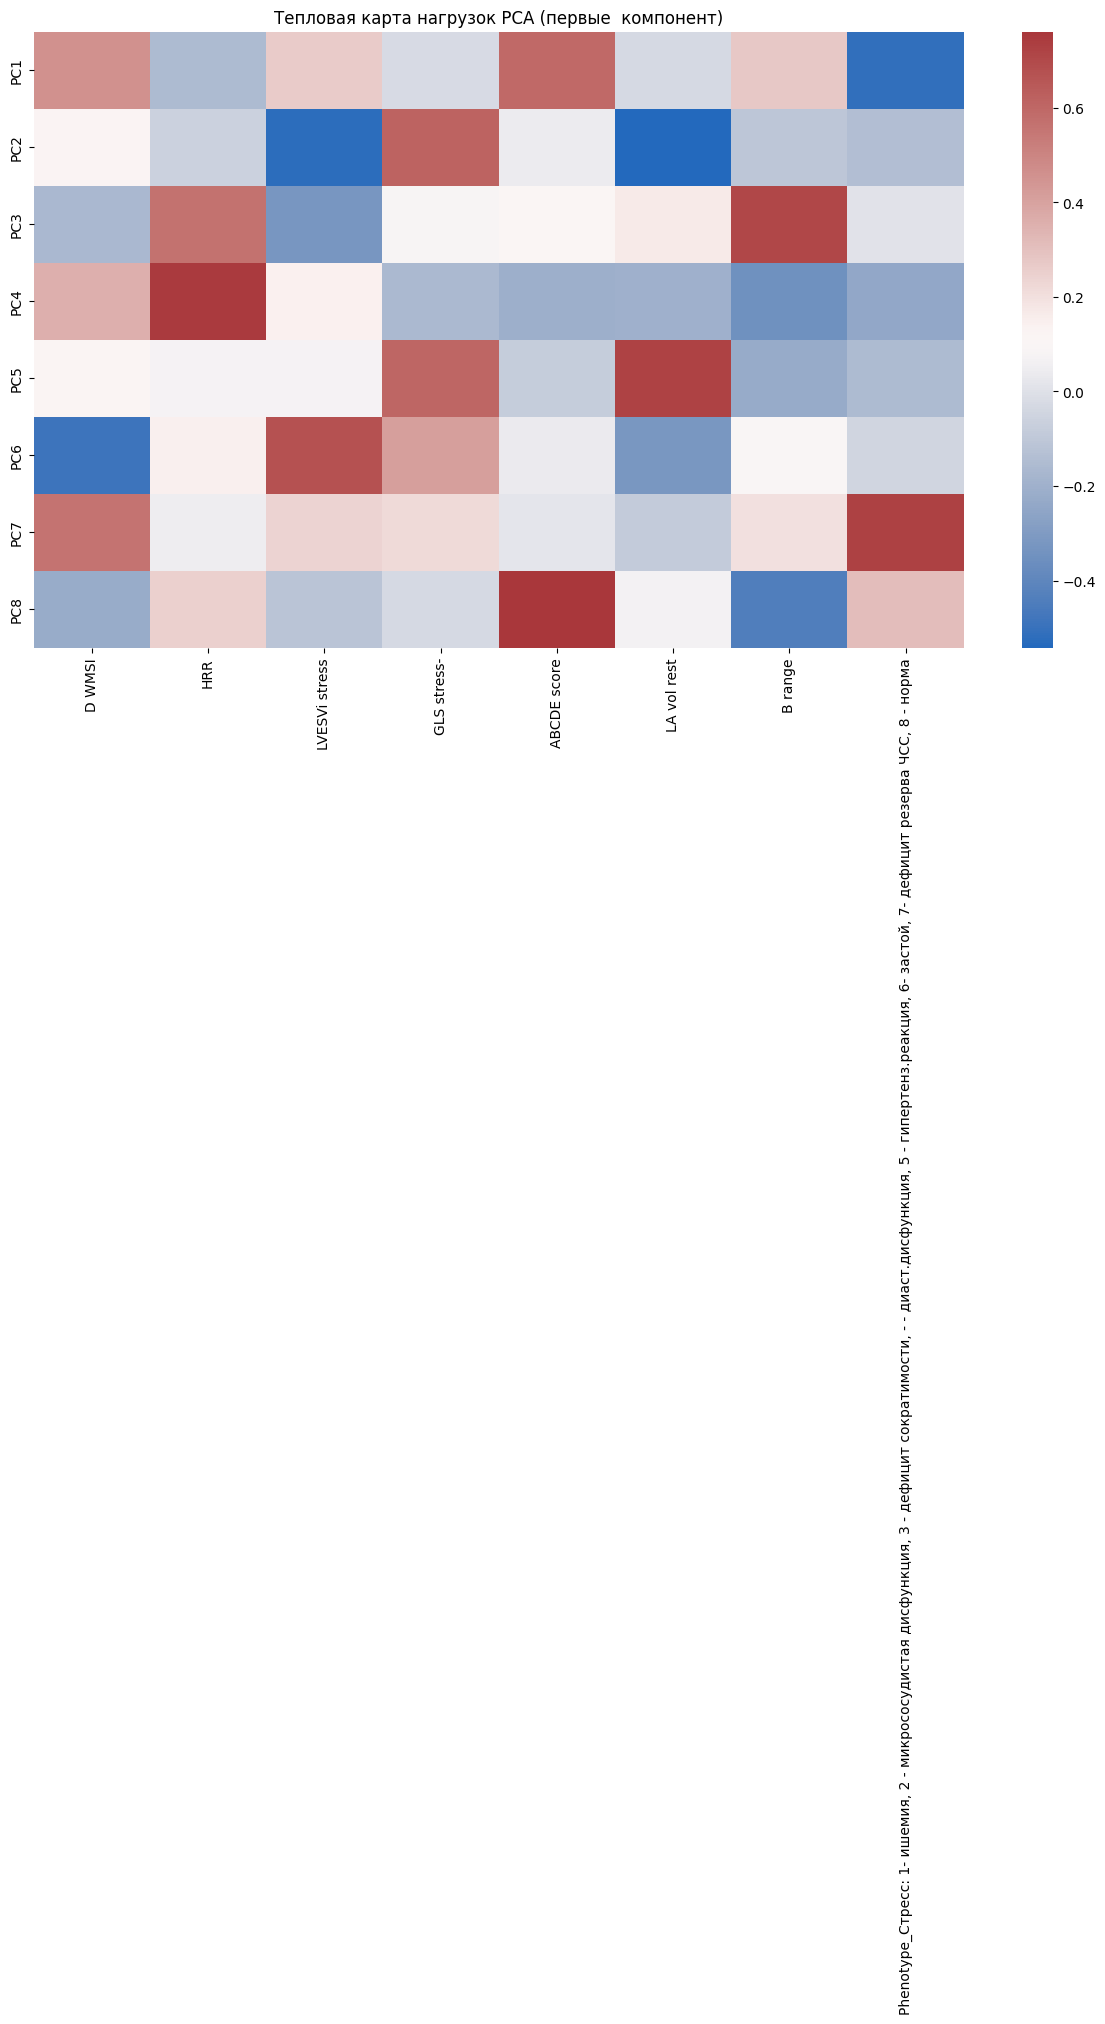

In [ ]:
# @title Веса главных компонент по всем признакам
data=df_MICE[optimal_cols]
X_numeric = data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]

for i in range(1,len(data.columns)+1):
  print(get_most_important_features(f'PC{i}', loadings_df, n_features=1))

plt.figure(figsize=(15, 8))
sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False)
plt.title('Тепловая карта нагрузок PCA (первые  компонент)')
plt.show()

In [ ]:
# @title Optuna для XGBoostClassifier
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 20, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 9.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 1.5),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_boost, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, timeout=1800)

print("Best trial:")
print("AUC:", study.best_value)
print("Params:", study.best_params)

best_params = study.best_params
best_params['eval_metric'] = 'logloss'
model = XGBClassifier(**best_params, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [ ]:
# @title Optuna для CatBoostClassifier

def weighted_scorer_func(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return 0.5 * acc + 0.5 * rec

custom_scorer = make_scorer(weighted_scorer_func, greater_is_better=True)

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 50, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        # "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 2.0),
        "scale_pos_weight": len(y[y==0]) / len(y[y==1]),
        "verbose": False,
        "loss_function": "Logloss",
        "eval_metric": "Recall",
        "random_seed": 42,
        "early_stopping_rounds": 50
    }
    X_cv = X_boost.copy()
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_cv[cat_features] = encoder.fit_transform(X_cv[cat_features])
    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_cv, y, cv=cv, scoring='recall')
    return np.mean(scores)

# Запуск Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=700, show_progress_bar=True)

print("Лучшие параметры:\n", study.best_params)

# Финальная модель с лучшими параметрами
best_params = study.best_params
best_params.update({
    "loss_function": "Logloss",
    "eval_metric": "Recall",
    "random_seed": 42,
    "early_stopping_rounds": 50,
    "verbose": 100
})

best_model = CatBoostClassifier(**best_params)
X_optuna=X_boost.copy()
X_optuna[cat_features] = encoder.fit_transform(X_optuna[cat_features])
X_train, X_test, y_train, y_test = train_test_split(X_optuna, y, test_size=0.2, random_state=0, stratify=y)
best_model.fit(X_train, y_train)

# Оценка
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# AUC
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

In [ ]:
# @title Grid
from sklearn.metrics import make_scorer

def weighted_scorer_func(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return 0.5 * acc + 0.5 * rec

custom_scorer = make_scorer(weighted_scorer_func, greater_is_better=True)

X_cv = X_boost.copy()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_cv[cat_features] = encoder.fit_transform(X_cv[cat_features])

param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 4, 5, 6],
    'l2_leaf_reg': [3.0, 5.0, 9.0],
    'random_strength': [0.1, 1.0, 10.0],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'border_count': [32, 128],
    'scale_pos_weight': [len(y[y==0]) / len(y[y==1])]
}

model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="Recall",
    random_seed=42,
    early_stopping_rounds=50,
    verbose=10
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring=custom_scorer,
    n_jobs=-1,
    verbose=False
)

grid_search.fit(X_cv, y)

print("Лучшие параметры:\n", grid_search.best_params_)
best_model = grid_search.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(
    X_cv, y, test_size=0.2, random_state=0, stratify=y
)

best_model.fit(X_train, y_train, verbose=100)
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# AUC
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()